In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [2]:
target = "Yield_Mg_ha"

## 1. Traits

In [3]:
df_trait = pd.read_csv("./1_Training_Trait_Data_2014_2021_cleaned_phil_V3.csv", sep=';')

/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (21,23,25,35,36,39,42,43,44,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
drop = (df_trait["YLD_DQ"] != 'discard') & (df_trait["MST_DQ"] != 'discard') & (df_trait["TWT_DQ"] != 'discard')

In [5]:
df_trait = pd.read_csv("./1_Training_Trait_Data_2014_2021.csv")

In [6]:
df_trait.shape, drop.shape

((136012, 26), (136012,))

In [7]:
with pd.option_context("display.max_columns", None):
    display(df_trait.head())

,Env,Year,Field_Location,Experiment,Replicate,Block,Plot,Range,Pass,Hybrid,Hybrid_orig_name,Hybrid_Parent1,Hybrid_Parent2,Plot_Area_ha,Date_Planted,Date_Harvested,Stand_Count_plants,Pollen_DAP_days,Silk_DAP_days,Plant_Height_cm,Ear_Height_cm,Root_Lodging_plants,Stalk_Lodging_plants,Yield_Mg_ha,Grain_Moisture,Twt_kg_m3
0,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,1,1.0,1.0,M0088/LH185,M0088/LH185,M0088,LH185,0.000716,5/5/14,9/29/14,56.0,63.0,67.0,213.0,79.0,0.0,0.0,5.721725,20.8,706.664693
1,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,2,1.0,2.0,M0143/LH185,M0143/LH185,M0143,LH185,0.000716,5/5/14,9/29/14,54.0,61.0,63.0,286.0,172.0,0.0,0.0,11.338246,25.8,693.792841
2,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,3,1.0,3.0,M0003/LH185,M0003/LH185,M0003,LH185,0.000716,5/5/14,9/29/14,60.0,63.0,65.0,239.0,92.0,0.0,4.0,6.540810,20.8,698.941582
3,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,4,1.0,4.0,M0035/LH185,M0035/LH185,M0035,LH185,0.000716,5/5/14,9/29/14,59.0,61.0,63.0,242.0,118.0,0.0,0.0,10.366857,23.7,711.813434
4,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,5,1.0,5.0,M0052/LH185,M0052/LH185,M0052,LH185,0.000716,5/5/14,9/29/14,58.0,63.0,65.0,211.0,92.0,0.0,0.0,10.908814,19.4,743.993065


In [8]:
df_trait.shape

(136012, 26)

In [9]:
df_trait.loc[df_trait["Hybrid_Parent1"].isna(), "Hybrid_Parent1"] = df_trait.loc[df_trait["Hybrid_Parent1"].isna()]["Hybrid"]
df_trait.loc[df_trait["Hybrid_Parent2"].isna(), "Hybrid_Parent2"] = df_trait.loc[df_trait["Hybrid_Parent2"].isna()]["Hybrid"]

In [10]:
trait_cols = [
    "Env",
    "Year",
    "Field_Location",
    "Hybrid_Parent1",
    "Hybrid_Parent2", 
    "Date_Planted",
    "Date_Harvested",
    "Stand_Count_plants",
    "Pollen_DAP_days",
    "Silk_DAP_days",
    "Plant_Height_cm",
    "Ear_Height_cm",
    "Yield_Mg_ha",
]

In [11]:
df_trait["Date_Planted"] = pd.to_datetime(df_trait["Date_Planted"]).map(lambda t: t.dayofyear)
df_trait["Date_Harvested"] = pd.to_datetime(df_trait["Date_Harvested"]).map(lambda t: t.dayofyear)

In [12]:
df_trait["Date_Planted"] = df_trait["Date_Planted"].fillna(df_trait["Date_Planted"].value_counts().index[0])
df_trait["Date_Harvested"] = df_trait["Date_Harvested"].fillna(df_trait["Date_Harvested"].value_counts().index[0])

In [13]:
df_trait["Yield_Mg_ha"].isna().sum()

7845

In [14]:
df_trait = df_trait.loc[~df_trait["Yield_Mg_ha"].isna()].reset_index(drop=True)

/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


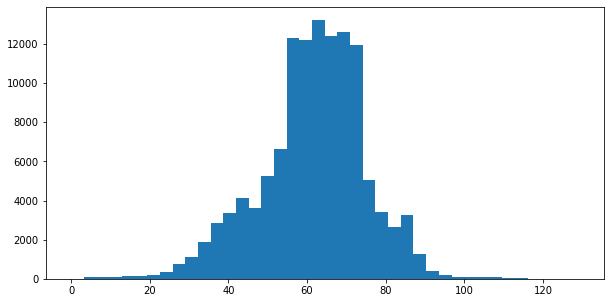

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(df_trait["Stand_Count_plants"], bins=40)
plt.show()

In [16]:
df_trait["Stand_Count_plants"] = df_trait["Stand_Count_plants"].fillna(df_trait["Stand_Count_plants"].median())

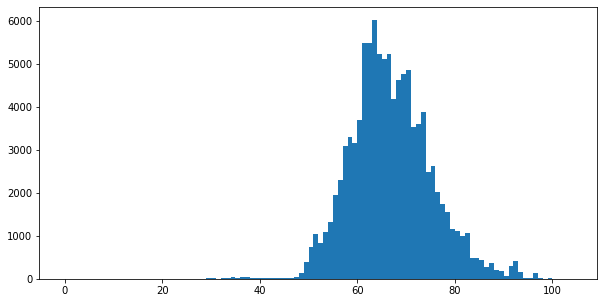

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(df_trait["Pollen_DAP_days"], bins=np.arange(105))
plt.show()

In [18]:
df_trait["Pollen_DAP_days"] = df_trait["Pollen_DAP_days"].fillna(df_trait["Pollen_DAP_days"].median())

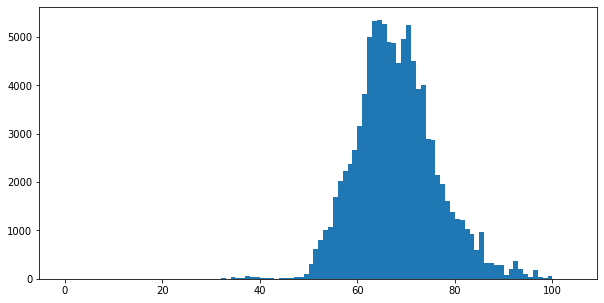

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(df_trait["Silk_DAP_days"], bins=np.arange(105))
plt.show()

In [20]:
df_trait["Silk_DAP_days"] = df_trait["Silk_DAP_days"].fillna(df_trait["Silk_DAP_days"].median())

/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


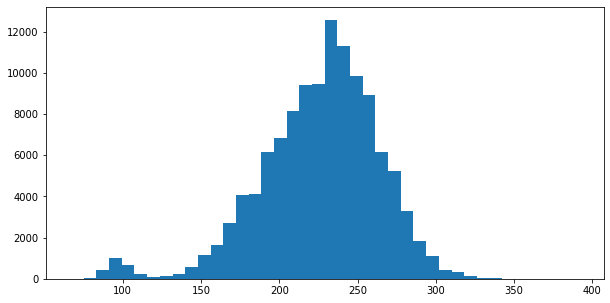

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(df_trait["Plant_Height_cm"], bins=40)
plt.show()

In [22]:
df_trait["Plant_Height_cm"] = df_trait["Plant_Height_cm"].fillna(df_trait["Plant_Height_cm"].median())

/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


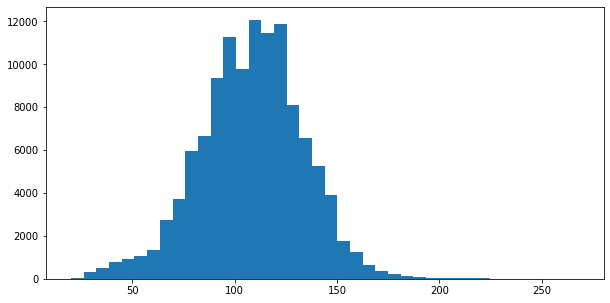

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(df_trait["Ear_Height_cm"], bins=40)
plt.show()

In [24]:
df_trait["Ear_Height_cm"] = df_trait["Ear_Height_cm"].fillna(df_trait["Ear_Height_cm"].median())

In [25]:
df_trait[trait_cols].isna().sum()

Env                   0
Year                  0
Field_Location        0
Hybrid_Parent1        0
Hybrid_Parent2        0
Date_Planted          0
Date_Harvested        0
Stand_Count_plants    0
Pollen_DAP_days       0
Silk_DAP_days         0
Plant_Height_cm       0
Ear_Height_cm         0
Yield_Mg_ha           0
dtype: int64

In [26]:
df_trait["not_discard"] = drop

In [27]:
df_trait.to_csv("./1_trait_cleaned.csv", index=False)

## 2. Meta

In [28]:
# df_meta = pd.read_csv("./2_Training_Meta_Data_2014_2021.csv", encoding = "ISO-8859-1")
df_meta = pd.read_csv("./2_Training_Meta_Data_2014_2021_V3.csv", encoding = "ISO-8859-1", sep=';')

df_meta.iloc[:1]

,ï»¿Year,Env,onsite weather,Experiment_Code,Treatment,weather notes,Irrigation data,City,State,Farm,...,Date_Planted,avg_Yield_Mg_ha,avg_yield_bu/a,Issue/comment_#1,Issue/comment_#2,Issue/comment_#3,Issue/comment_#4,Issue/comment_#5,Issue/comment_#6,Comments
0,2016,ARH1_2016,8658,ARH1,Irrigated,NaN,Irrigation unknown amt,Marianna,Arkansas,NaN,...,07/04/2016,"6,50","96,67",Large pigweed in field at harvest August 30 an...,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# df_meta = df_meta.loc[~df_meta["Env"].isna()]
df_meta.shape

(217, 44)

In [30]:
df_meta[[
    'Latitude_of_Field_Corner_#1 (lower left)',
    'Longitude_of_Field_Corner_#1 (lower left)',
    'Latitude_of_Field_Corner_#2 (lower right)',
    'Longitude_of_Field_Corner_#2 (lower right)',
    'Latitude_of_Field_Corner_#3 (upper right)',
    'Longitude_of_Field_Corner_#3 (upper right)',
    'Latitude_of_Field_Corner_#4 (upper left)',
    'Longitude_of_Field_Corner_#4 (upper left)'
]].isna().sum()

Latitude_of_Field_Corner_#1 (lower left)      52
Longitude_of_Field_Corner_#1 (lower left)     52
Latitude_of_Field_Corner_#2 (lower right)     54
Longitude_of_Field_Corner_#2 (lower right)    54
Latitude_of_Field_Corner_#3 (upper right)     54
Longitude_of_Field_Corner_#3 (upper right)    54
Latitude_of_Field_Corner_#4 (upper left)      53
Longitude_of_Field_Corner_#4 (upper left)     53
dtype: int64

In [31]:
df_meta = df_meta.rename({'ï»¿Year': 'Year'}, axis=1)
# 

In [32]:
meta_cols = [
    "Env",
    "Year",
    "Previous_Crop",
    "City",
    "Treatment",
#     "Pre-plant_tillage_method(s)",
#     "Irrigated",
]

In [33]:
df_meta["Treatment"].value_counts()

Standard          169
Irrigated          39
Disease trial       4
Late Planting       3
Early Planting      1
Late Stressed       1
Name: Treatment, dtype: int64

In [34]:
df_meta[meta_cols]

,Env,Year,Previous_Crop,City,Treatment
0,ARH1_2016,2016,corn,Marianna,Irrigated
1,ARH1_2017,2017,corn,Marianna,Irrigated
2,ARH1_2018,2018,corn,Marianna,Irrigated
3,ARH2_2016,2016,soybean,Jonesboro,Standard
4,ARH2_2017,2017,corn,Keiser,Irrigated
...,...,...,...,...,...
212,WIH2_2019,2019,soybean,Arlington,Standard
213,WIH2_2020,2020,soybean,Arlington,Standard
214,WIH2_2021,2021,soybean,Arlington,Standard
215,WIH3_2020,2020,NaN,Hancock,Irrigated


In [35]:
df_meta["Treatment"].value_counts()

Standard          169
Irrigated          39
Disease trial       4
Late Planting       3
Early Planting      1
Late Stressed       1
Name: Treatment, dtype: int64

In [36]:
df_meta["Pre-plant_tillage_method(s)"].value_counts()

field cultivator                                  20
Conventional                                       7
conventional                                       6
Field cultivator                                   6
fall chisel plow, spring field cultivator          5
                                                  ..
Fall rip one pass tool, spring field cultivate     1
Chisel - field cultivator                          1
chisel, field cultivate                            1
Chisel plow and field cultivator                   1
Disc, Dynadrive                                    1
Name: Pre-plant_tillage_method(s), Length: 101, dtype: int64

In [37]:
df_meta["Previous_Crop"] = df_meta["Previous_Crop"].fillna("soybean")
df_meta["City"] = df_meta["City"].fillna("unknown")

In [38]:
df_meta[meta_cols].isna().sum()

Env              0
Year             0
Previous_Crop    0
City             0
Treatment        0
dtype: int64

In [39]:
df_meta[meta_cols].to_csv("./2_meta_cleaned.csv", index=False)

## 3. Soil

In [40]:
df_soil = pd.read_csv("./3_Training_Soil_Data_2015_2021.csv")
with pd.option_context("display.max_columns", None):
    display(df_soil.head())

,Year,Env,LabID,Date Received,Date Reported,E Depth,1:1 Soil pH,WDRF Buffer pH,1:1 S Salts mmho/cm,Texture No,Organic Matter LOI %,Nitrate-N ppm N,lbs N/A,Potassium ppm K,Sulfate-S ppm S,Calcium ppm Ca,Magnesium ppm Mg,Sodium ppm Na,CEC/Sum of Cations me/100g,%H Sat,%K Sat,%Ca Sat,%Mg Sat,%Na Sat,Mehlich P-III ppm P,% Sand,% Silt,% Clay,Texture,BpH,Zinc ppm Zn,Iron ppm Fe,Manganese ppm Mn,Copper ppm Cu,Boron ppm B,Comments
0,2021,NEH3_2021,Ward Laboratories Inc,08/31/2021,09/02/2021,12.0,5.8,6.8,0.26,2.0,3.0,28.9,104.0,147.0,4.70,1391.0,223.0,13.0,11.2,17.0,3.00,62.00,17.00,1.00,42.0,25.0,53.0,22.0,Silt Loam,NaN,NaN,NaN,NaN,NaN,NaN,Results referent to NEH2_2021 and NEH3_2021
1,2020,MOH1_1_2020,Ward Laboratories Inc,9/16/20,9/18/20,12.0,6.1,6.9,0.36,2.0,2.4,54.9,198.0,100.0,4.75,1750.0,208.0,21.0,11.7,7.0,2.00,75.00,15.00,1.00,21.0,19.0,67.0,14.0,Silt Loam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,ARH1_2016,Local Lab,NaN,4/8/2016,12.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,123.0,7.00,1676.0,389.0,NaN,NaN,NaN,2.25,59.66,23.08,0.77,40.0,NaN,NaN,NaN,Silt Loam-Silty Clay Loam,NaN,3.6,174.0,161.0,1.9,0.3,NaN
3,2016,ARH2_2016,Local Lab,NaN,4/12/2016,12.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,76.0,11.00,817.0,214.0,NaN,NaN,NaN,2.30,47.30,20.70,0.80,26.0,NaN,NaN,NaN,Silt Loam,NaN,1.9,131.0,248.0,1.5,0.0,NaN
4,2016,DEH1_2016,Ward Laboratories Inc,5/19/2016,5/23/2016,12.0,5.7,6.4,0.37,2.0,2.3,34.4,124.0,174.0,19.00,495.0,110.0,9.0,9.4,59.0,5.00,26.00,10.00,0.00,157.0,75.0,13.0,12.0,Sandy Loam,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_soil.isna().sum()

Year                            0
Env                             0
LabID                           0
Date Received                  17
Date Reported                   0
E Depth                        15
1:1 Soil pH                     2
WDRF Buffer pH                 19
1:1 S Salts mmho/cm            19
Texture No                     15
Organic Matter LOI %            8
Nitrate-N ppm N                17
lbs N/A                        19
Potassium ppm K                 0
Sulfate-S ppm S                19
Calcium ppm Ca                 15
Magnesium ppm Mg               15
Sodium ppm Na                  17
CEC/Sum of Cations me/100g     19
%H Sat                         19
%K Sat                         17
%Ca Sat                        17
%Mg Sat                        17
%Na Sat                        17
Mehlich P-III ppm P             0
% Sand                         23
% Silt                         23
% Clay                         23
Texture                        21
BpH           

In [42]:
df_soil = df_soil.merge(df_trait["Env"].drop_duplicates(), on="Env", how="outer")

In [43]:
df_soil["Year"] = df_soil["Env"].map(lambda s: int(s.split('_')[-1]))

In [44]:
soil_cols = [
    'Year',
    'Env',
    'E Depth',
    '1:1 Soil pH',
    'WDRF Buffer pH',
    '1:1 S Salts mmho/cm',
    'Texture No',
    'Organic Matter LOI %',
    'Nitrate-N ppm N',
    'lbs N/A',
    'Potassium ppm K',
    'Sulfate-S ppm S',
    'Calcium ppm Ca',
    'Magnesium ppm Mg',
    'Sodium ppm Na',
    'CEC/Sum of Cations me/100g',
    '%H Sat',
    '%K Sat',
    '%Ca Sat',
    '%Mg Sat',
    '%Na Sat',
    'Mehlich P-III ppm P',
    '% Sand',
    '% Silt',
    '% Clay',
    'Texture',
]

In [45]:
df_soil["Env_pure"] = df_soil["Env"].map(lambda s: s.split('_')[0])

In [46]:
df_soil.iloc[:, :-8].isna().sum(axis=0)

Year                           0
Env                            0
LabID                         76
Date Received                 93
Date Reported                 76
E Depth                       91
1:1 Soil pH                   78
WDRF Buffer pH                95
1:1 S Salts mmho/cm           95
Texture No                    91
Organic Matter LOI %          84
Nitrate-N ppm N               93
lbs N/A                       95
Potassium ppm K               76
Sulfate-S ppm S               95
Calcium ppm Ca                91
Magnesium ppm Mg              91
Sodium ppm Na                 93
CEC/Sum of Cations me/100g    95
%H Sat                        95
%K Sat                        93
%Ca Sat                       93
%Mg Sat                       93
%Na Sat                       93
Mehlich P-III ppm P           76
% Sand                        99
% Silt                        99
% Clay                        99
Texture                       97
dtype: int64

In [47]:
# we try to fill the missing values by the same env from other years

In [48]:
# NB
env_na_counts = df_soil["Env_pure"].value_counts()[df_soil.loc[df_soil.iloc[:, :-8].isna().any(axis=1)]["Env_pure"].value_counts().index] - df_soil.loc[df_soil.iloc[:, :-8].isna().any(axis=1)]["Env_pure"].value_counts()
env_na_counts

ILH1          2
TXH2          3
NYH1          2
IAH3          3
IAH4          3
GAH1          4
ONH2          1
NEH2          2
NCH1          5
NEH1          3
DEH1          5
ARH2          0
TXH1          3
ARH1          0
NEH3          2
MNH1          5
KSH1          0
INH1          5
IAH2          3
IAH1          4
OHH1          4
TXH1-Early    0
NEH4          1
TXH1-Late     0
ONH1          2
TXH1-Dry      0
MOH2          0
WIH1          6
NYH2          6
MOH1          7
IAH1c         0
IAH1b         0
IAH1a         0
WIH2          6
SDH1          0
NYH3          5
SCH1          3
TXH4          0
COH1          1
Name: Env_pure, dtype: int64

In [49]:
zero_envs = set(env_na_counts[env_na_counts == 0].index)
df_trait["Env"].map(lambda s: s.split('_')[0] in zero_envs).sum()

10505

In [50]:
medians = df_soil.groupby("Env_pure")[soil_cols[2:-1]].median()
medians["Texture"] = df_soil.groupby("Env_pure").apply(
    lambda df: df["Texture"].value_counts().index[0] if not df["Texture"].isna().all() else np.nan
)

In [51]:
for colname in soil_cols[2:]:
    df_soil[colname] = df_soil.apply(
        lambda row: row[colname] if (isinstance(row[colname], str) or not np.isnan(row[colname])) else medians.loc[row["Env_pure"], colname],
        axis=1
    )

In [52]:
df_soil[soil_cols].isna().sum()

Year                           0
Env                            0
E Depth                       16
1:1 Soil pH                   16
WDRF Buffer pH                22
1:1 S Salts mmho/cm           22
Texture No                    16
Organic Matter LOI %          16
Nitrate-N ppm N               22
lbs N/A                       22
Potassium ppm K               10
Sulfate-S ppm S               16
Calcium ppm Ca                16
Magnesium ppm Mg              16
Sodium ppm Na                 22
CEC/Sum of Cations me/100g    22
%H Sat                        22
%K Sat                        16
%Ca Sat                       16
%Mg Sat                       16
%Na Sat                       16
Mehlich P-III ppm P           10
% Sand                        22
% Silt                        22
% Clay                        22
Texture                       16
dtype: int64

In [53]:
df_soil[soil_cols].to_csv("./3_soil_cleaned.csv", index=False)

## 4. Weather

In [99]:
df_weather = pd.read_csv("./4_Training_Weather_Data_2014_2021.csv")

In [100]:
df_weather["Date"] = pd.to_datetime(df_weather["Date"].astype(str)).map(lambda s: s.dayofyear)

In [101]:
# let's average by week starting from planting date (or by equal periods)

In [102]:
# check the envs where there were more than 1 planting date (there's only a few of them)
datecol = "Date_Planted"
xx = df_trait.groupby("Env").apply(lambda df: df[datecol].value_counts().shape[0])
df_trait.loc[df_trait["Env"].isin(xx[xx > 1].index)].groupby(["Env"]).apply(
    lambda df: df[datecol].max() - df[datecol].min()
).value_counts()
# left is diff in days between earliest and latest date for env, right is how many fields with this diff

1.0     3
8.0     2
10.0    1
22.0    1
19.0    1
dtype: int64

In [103]:
# same for harvesting date
datecol = "Date_Harvested"
xx = df_trait.groupby("Env").apply(lambda df: df[datecol].value_counts().shape[0])
df_trait.loc[df_trait["Env"].isin(xx[xx > 1].index)].groupby(["Env"]).apply(
    lambda df: df[datecol].max() - df[datecol].min()
).value_counts()
# left is diff in days between earliest and latest date for env, right is how many fields with this diff
# still looks ok

1.0     40
2.0      9
7.0      5
3.0      3
4.0      2
23.0     2
8.0      1
36.0     1
6.0      1
5.0      1
13.0     1
11.0     1
16.0     1
32.0     1
9.0      1
dtype: int64

In [104]:
env_to_planting_date = df_trait.groupby("Env")["Date_Planted"].min()
env_to_harvesting_date = df_trait.groupby("Env")["Date_Harvested"].max()

In [105]:
df_weather["Date_Planted"] = df_weather["Env"].map(env_to_planting_date)
df_weather["Date_Harvested"] = df_weather["Env"].map(env_to_harvesting_date)

In [106]:
df_weather["Days_from_planting"] = df_weather["Date"] - df_weather["Date_Planted"]

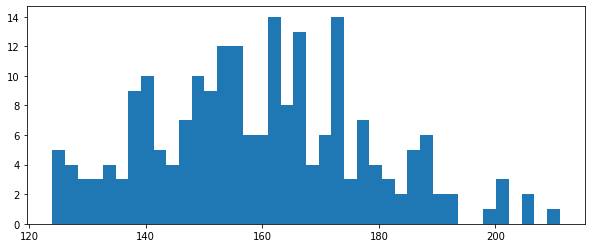

In [107]:
plt.figure(figsize=(10, 4))
plt.hist(df_weather.loc[(df_weather["Days_from_planting"] >= 0) & (df_weather["Date"] < df_weather["Date_Harvested"])].\
    groupby("Env")["Days_from_planting"].max(), bins=40)
plt.show()

In [108]:
# let's limit by 180 for simplicity

# let's now split for each env the whole time into 5 equal periods and average on them 
# (this will give us 17*5 columns)

In [109]:
df_weather = df_weather.loc[
    (df_weather["Days_from_planting"] >= 0) & \
    (df_weather["Date"] < df_weather["Date_Harvested"])
]

In [110]:
df_weather["VPD"] = \
    610.78 * np.e**(df_weather[f"T2M"] / (df_weather[f"T2M"] + 237.3) * 17.2694)*(1 - df_weather["RH2M"]/100) / 1000

In [111]:
df_weather["GDU"] = (
    (
        (
            df_weather["T2M_MIN"].clip(10, 30) + df_weather["T2M_MAX"].clip(10, 30)
        ) / 2
    ) - 10
) * 1.8 ## for daily weather only!!


In [114]:
def gdu_cumsum(df_group):
    df_group = df_group.sort_values(by='Days_from_planting').reset_index(drop=True)
    df_group["GDU_accum"] = np.cumsum(df_group["GDU"])
    return df_group
    
df_weather = df_weather.groupby('Env').apply(gdu_cumsum).reset_index(drop=True)

In [131]:
cols = ['Env', 'PRECTOTCORR', 'T2M_MIN', 'T2M', 'T2M_MAX', 'VPD', 'WS2M', 'GDU_accum']

#### 1

In [ ]:
# heat = ['Env', 'T2M_MIN', 'T2M', 'T2M_MAX', 'GDU_accum'] + soil -> s_h ()
# drought = ['Env', 'PRECTOTCORR', 'VPD', 'WS2M', 'GDU_accum'] + soil -> s_d

In [ ]:
# [genetics (50), s_h (17x1), s_d (17x1), ec(20), 'loc'] -> mlp -> 1

#### 2

In [ ]:
# Stage Description 	Stage categories for modeling  	Period description 	Beginning of period 	End of period
# Germination to emergence 	pGerEme 	germination and emergence 	Planting date 	120 GDU
# Emergence to end of juvenile 	pEmeEnJ+pEnJFlo 	emergence to floral initiation 	120 GDU 	820 GDU
# End of juvenile to floral initiation
# Floral initiation to flag leaf 	pFloFla+pFlaFlw 	Maximum vegetative growth 	820 GDU 	SILK_GDU  (calculate accumulated GDU from planting to Silk_DAP)
# Flag leaf to flowering
# Flowering to start of grain fill 	pFlwStG 	Polination and grain initiation 	Silk_GDU 	Silk_GDU+300
# Start of grain fill to end of grain fill 	pStGEnG 	Grain fill 	Silk_GDU+300 	Silk_GDU+1150

In [130]:
# silk_DAP = f(genetics (50))

In [132]:
df_weather_full = df_weather[cols]
df_weather_full.to_csv("./4_weather_full.csv", index=False)

In [134]:
df_weather_full.query("Env == 'ARH1_2016'")

,Env,PRECTOTCORR,T2M_MIN,T2M,T2M_MAX,VPD,WS2M,GDU_accum
0,ARH1_2016,0.00,7.19,15.40,23.84,0.501972,2.96,12.456
1,ARH1_2016,0.00,6.35,12.19,18.40,0.441949,3.19,20.016
2,ARH1_2016,0.12,5.93,11.87,17.73,0.431890,2.26,26.973
3,ARH1_2016,0.19,11.47,18.05,24.32,0.583626,5.15,41.184
4,ARH1_2016,28.10,11.70,17.93,22.36,0.235066,4.07,53.838
...,...,...,...,...,...,...,...,...
140,ARH1_2016,0.00,25.06,29.47,34.24,1.065056,0.73,3530.349
141,ARH1_2016,5.14,25.29,28.30,32.67,0.761910,0.94,3562.110
142,ARH1_2016,0.24,23.08,28.66,34.51,1.163254,1.27,3591.882
143,ARH1_2016,0.33,23.04,29.49,36.37,1.388063,1.75,3621.618


In [89]:
df_weather[cols]

,PRECTOTCORR,T2M_MIN,T2M_MAX,VPD,WS2M
97,0.00,7.19,23.84,0.501972,2.96
98,0.00,6.35,18.40,0.441949,3.19
99,0.12,5.93,17.73,0.431890,2.26
100,0.19,11.47,24.32,0.583626,5.15
101,28.10,11.70,22.36,0.235066,4.07
...,...,...,...,...,...
77321,2.08,19.15,28.56,0.940663,2.10
77322,0.02,17.65,32.27,1.442708,2.89
77323,0.00,19.16,32.81,1.815331,3.00
77324,0.00,18.82,31.27,1.683885,3.14


In [84]:
weather_cols = df_weather.columns
def average_by_periods(df, columns, n_periods=5):
    row = {}
    period_length = df["Days_from_planting"].max() / n_periods
    for period in range(n_periods):
        sub_df = df.loc[
            (df["Days_from_planting"] >= (period_length * period)) & \
            (df["Days_from_planting"] < (period_length * (period+1)))
        ]
        
        if period == 0:
            row[f"PRECTOTCORR_{period}"] = sub_df["PRECTOTCORR"].sum()
            row[f"T2M_MIN_{period}"] = sub_df["T2M_MIN"].mean()
#             row[f"GWETROOT_{period}"] = sub_df["GWETROOT"].mean()
            #ECDD
        elif period == 1:
            row[f"PRECTOTCORR_{period}"] = sub_df["PRECTOTCORR"].sum()
            row[f"T2M_MIN_{period}"] = sub_df["T2M_MIN"].mean()
            row[f"N_NEG_DAYS_{period}"] = (sub_df["T2M_MIN"] < 0).sum()
            row[f"WS2M_{period}"] = sub_df["WS2M"].max()
#             row[f"GWETROOT_{period}"] = sub_df["GWETROOT"].mean()
        elif period == 2:
            row[f"PRECTOTCORR_{period}"] = sub_df["PRECTOTCORR"].sum()
            row[f"T2M_MAX_{period}"] = sub_df["T2M_MAX"].mean()
            row[f"T2M_MIN_{period}"] = sub_df["T2M_MIN"].mean()
            row[f"WS2M_{period}"] = sub_df["WS2M"].max()
#             row[f"GWETROOT_{period}"] = sub_df["GWETROOT"].mean()
            row[f"VPD_{period}"] = sub_df["VPD"].mean()
            #EDD
        elif period == 3:
            row[f"PRECTOTCORR_{period}"] = sub_df["PRECTOTCORR"].sum()
            row[f"T2M_MAX_{period}"] = sub_df["T2M_MAX"].mean()
            row[f"T2M_MIN_{period}"] = sub_df["T2M_MIN"].mean()
            row[f"WS2M_{period}"] = sub_df["WS2M"].max()
#             row[f"GWETROOT_{period}"] = sub_df["GWETROOT"].mean()
            row[f"VPD_{period}"] = sub_df["VPD"].mean()
            #EDD, ECDD
        elif period == 4:
            row[f"PRECTOTCORR_{period}"] = sub_df["PRECTOTCORR"].sum()
            row[f"T2M_MAX_{period}"] = sub_df["T2M_MAX"].mean()
            row[f"T2M_MIN_{period}"] = sub_df["T2M_MIN"].mean()
            row[f"N_NEG_DAYS_{period}"] = (sub_df["T2M_MIN"] < 0).sum()
            row[f"WS2M_{period}"] = sub_df["WS2M"].max()
#             row[f"GWETROOT_{period}"] = sub_df["GWETROOT"].mean()
            row[f"VPD_{period}"] = sub_df["VPD"].mean()
            #EDD, ECDD
            

    return pd.Series(row)

In [85]:
df_weather_averaged = df_weather.groupby("Env").apply(lambda df: average_by_periods(
    df,
    columns=list(set(df_weather.columns) - {'Env', 'Date', 'Date_Planted', 'Date_Harvested', 'df_weather.columns'}),
    n_periods=5,
)).reset_index()

In [87]:
df_weather_averaged.columns

Index(['Env', 'PRECTOTCORR_0', 'T2M_MIN_0', 'PRECTOTCORR_1', 'T2M_MIN_1',
       'N_NEG_DAYS_1', 'WS2M_1', 'PRECTOTCORR_2', 'T2M_MAX_2', 'T2M_MIN_2',
       'WS2M_2', 'VPD_2', 'PRECTOTCORR_3', 'T2M_MAX_3', 'T2M_MIN_3', 'WS2M_3',
       'VPD_3', 'PRECTOTCORR_4', 'T2M_MAX_4', 'T2M_MIN_4', 'N_NEG_DAYS_4',
       'WS2M_4', 'VPD_4'],
      dtype='object')

In [101]:
df_weather_averaged["Year"] = df_weather_averaged["Env"].map(lambda s: int(s.split('_')[-1]))
df_weather_averaged = df_weather_averaged[["Env", "Year"] + sorted(df_weather_averaged.columns[1:-1])]

In [118]:
weather_scaler = StandardScaler()
weather_scaler.fit(df_weather_averaged.query("Year < 2021").iloc[:, 2:])
clusterer = KMeans(n_clusters=8)
clusterer.fit(weather_scaler.transform(df_weather_averaged.query("Year < 2021").iloc[:, 2:]))

KMeans()

In [124]:
dump(weather_scaler, "./weather_scaler.joblib")
dump(clusterer, "./weather_clusterer.joblib")

['./weather_clusterer.joblib']

In [119]:
scenarios = clusterer.predict(weather_scaler.transform(df_weather_averaged.iloc[:, 2:]))
df_weather_averaged["scenario"] = scenarios
pd.Series(scenarios).value_counts()

In [122]:
df_weather_averaged.to_csv("./4_weather_averaged.csv", index=False)

## 5. Strains  (logistic SVD/PCA in another notebook)

In [465]:
df_strain = pd.read_csv("./strain.csv")
# df_strain = df_strain.set_index("strain")

In [466]:
df_strain

,strain,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50
0,2369,-1688.209248,-829.192393,134.539912,-65.046161,32.638545,-765.825520,-420.298496,140.254360,-274.662855,...,60.168819,261.425822,-125.412044,-308.040635,-100.933971,389.579470,140.815876,-393.041455,204.575780,-53.725272
1,2FACC,-50.934458,839.587276,277.682769,866.670175,667.769114,-172.364034,44.734925,102.877251,-105.922844,...,220.686741,565.680379,-46.750418,428.967608,-118.448039,-35.135522,-69.061610,-239.562959,80.115924,17.032275
2,4N506,-1177.221603,110.105434,-61.652410,430.553212,-195.273463,-492.641358,-134.649178,146.667693,135.341639,...,57.609670,198.050811,110.363929,53.083358,-96.963968,-435.691138,-136.727222,192.252259,374.375646,396.647014
3,6F629,-1042.940541,614.693322,-133.316078,760.149227,-269.146314,-242.329977,3.555848,-52.314259,-24.849891,...,-187.212197,197.931534,12.173633,-144.286119,-49.780724,-2.271437,9.435327,203.055899,86.161039,256.435646
4,740,-527.868697,1172.616750,145.096510,-317.877646,-47.501212,-704.981072,-1036.674695,-301.185469,172.112116,...,242.396880,123.842714,-70.425523,-70.428380,-56.904291,186.884394,-119.125113,117.456240,-207.902624,11.904483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,Z035E0060,-2055.890328,-1953.150894,70.072799,-111.029402,372.263513,-1308.405940,-320.092454,500.461519,-379.528280,...,-5.515097,-584.760465,74.815310,331.822260,266.172946,-204.350954,32.582350,-51.677766,-62.465891,-46.948567
2200,Z036E0057,-2323.436671,-2075.055658,18.569257,-70.832876,118.823092,-883.959271,-220.717645,373.081805,-252.784371,...,-64.576538,-60.458536,-73.032824,427.145816,-39.135163,-258.546656,-457.985514,-401.556793,169.629498,-135.322036
2201,Z037E0012,-2306.396773,-2359.880274,143.326408,-344.235235,404.583411,-1180.553636,-259.094239,276.993126,-417.365881,...,-377.250412,7.998896,-26.071063,174.335036,246.983704,-180.654246,91.805270,-140.168469,247.029765,-75.352252
2202,Z037E0054,-2136.167572,-2144.448086,43.534109,-319.954744,334.199129,-1158.805849,-234.999734,462.843111,-258.007071,...,-240.462769,-151.645328,355.900085,79.510906,238.717844,-226.944325,-136.504652,68.029944,191.574256,-187.393920


## 6. EC

In [5]:
df_ec = pd.read_csv("./6_Training_EC_Data_2014_2021.csv")
df_ec.isna().sum().max()

0

In [6]:
df_ec["Year"] = df_ec["Env"].map(lambda s: int(s.split('_')[-1]))

In [10]:
growth_stages = ["pGerEme", "pEmeEnJ", "pEnJFlo", "pFloFla", "pFlaFlw", "pFlwStG", "pStGEnG", "pEnGMat", "pMatHar"]

growth_stage_to_max_layer = {
    "pGerEme": 1,
    "pEmeEnJ": 3,
    "pEnJFlo": 3,
    "pFloFla": 10,
    "pFlaFlw": 10,
    "pFlwStG": 10,
    "pStGEnG": 10,
    "pMatHar": 0,
}
for growth_stage in growth_stages:
    for feature in ["SDR", "ESW", "Flow", "FlowNO3", "Flux", "PAWmm", "SWmm"]:
        try:
            df_ec[f"{feature}_{growth_stage}"] = sum([
                df_ec[f"{feature}_{growth_stage}_{soil_layer}"] for soil_layer in range(1, growth_stage_to_max_layer[growth_stage] + 1)
            ])
        except KeyError:
            pass

In [11]:

df_ec_filtered = pd.DataFrame()

df_ec_filtered["Env"] = df_ec["Env"]
df_ec_filtered["Year"] = df_ec["Year"]

df_ec_filtered["SDR_pGerEme"] = df_ec["SDR_pGerEme"]
df_ec_filtered["SDR_pEmeEnJ+pEnJFlo"] = df_ec["SDR_pEmeEnJ"]+df_ec["SDR_pEnJFlo"]
df_ec_filtered["SDR_pFloFla+pFlaFlw"] = df_ec["SDR_pFloFla"]+df_ec["SDR_pFlaFlw"]
df_ec_filtered["SDR_pFlwStG"] = df_ec["SDR_pFlwStG"]
df_ec_filtered["SDR_pStGEnG"] = df_ec["SDR_pStGEnG"]

df_ec_filtered["TT_pGerEme"] = df_ec["TT_pGerEme"]
df_ec_filtered["TT_pEmeEnJ+pEnJFlo"] = df_ec["TT_pEmeEnJ"]+df_ec["TT_pEnJFlo"]
df_ec_filtered["TT_pFloFla+pFlaFlw"] = df_ec["TT_pFloFla"]+df_ec["TT_pFlaFlw"]
df_ec_filtered["TT_pFlwStG"] = df_ec["TT_pFlwStG"]
df_ec_filtered["TT_pStGEnG"] = df_ec["TT_pStGEnG"]

df_ec_filtered["yield_pFloFla+pFlaFlw"] = df_ec["yield_pFloFla"]+df_ec["yield_pFlaFlw"]
df_ec_filtered["yield_pFlwStG"] = df_ec["yield_pFlwStG"]
df_ec_filtered["yield_pStGEnG"] = df_ec["yield_pStGEnG"]

df_ec_filtered["Eo_pFloFla+pFlaFlw"] = df_ec["Eo_pFloFla"]+df_ec["Eo_pFlaFlw"]
df_ec_filtered["Eo_pFlwStG"] = df_ec["Eo_pFlwStG"]
df_ec_filtered["Eo_pStGEnG"] = df_ec["Eo_pStGEnG"]

df_ec_filtered["ESW_pFloFla+pFlaFlw"] = df_ec["ESW_pFloFla"]+df_ec["ESW_pFlaFlw"]
df_ec_filtered["ESW_pFlwStG"] = df_ec["ESW_pFlwStG"]
df_ec_filtered["ESW_pStGEnG"] = df_ec["ESW_pStGEnG"]

df_ec_filtered["FlowNO3_pFloFla+pFlaFlw"] = df_ec["FlowNO3_pFloFla"]+df_ec["FlowNO3_pFlaFlw"]
df_ec_filtered["FlowNO3_pFlwStG"] = df_ec["FlowNO3_pFlwStG"]

df_ec_filtered["PAWmm_pFloFla+pFlaFlw"] = df_ec["PAWmm_pFloFla"]+df_ec["PAWmm_pFlaFlw"]
df_ec_filtered["PAWmm_pFlwStG"] = df_ec["PAWmm_pFlwStG"]
df_ec_filtered["PAWmm_pStGEnG"] = df_ec["PAWmm_pStGEnG"]

df_ec_filtered["LAI_pEmeEnJ+pEnJFlo"] = df_ec["LAI_pEmeEnJ"]+df_ec["LAI_pEnJFlo"]
df_ec_filtered["LAI_pFloFla+pFlaFlw"] = df_ec["LAI_pFloFla"]+df_ec["LAI_pFlaFlw"]

df_ec_filtered["AccumulatedTT_pGerEme"] = df_ec["AccumulatedTT_pGerEme"]
df_ec_filtered["AccumulatedTT_pEmeEnJ+pEnJFlo"] = df_ec["AccumulatedTT_pEmeEnJ"]+df_ec["AccumulatedTT_pEnJFlo"]
df_ec_filtered["AccumulatedTT_pFloFla+pFlaFlw"] = df_ec["AccumulatedTT_pFloFla"]+df_ec["AccumulatedTT_pFlaFlw"]
df_ec_filtered["AccumulatedTT_pFlwStG"] = df_ec["AccumulatedTT_pFlwStG"]
df_ec_filtered["AccumulatedTT_pStGEnG"] = df_ec["AccumulatedTT_pStGEnG"]

df_ec_filtered.shape

(165, 33)

In [85]:
df_ec_filtered.to_csv("./6_ec_cleaned.csv", index=False)

# test

### test trait

In [125]:
df_trait_test = pd.read_csv("./1_Submission_Template_2022.csv")

In [127]:
df_trait_test["Hybrid_Parent1"] = df_trait_test["Hybrid"].map(lambda s: s.split('/')[0])
df_trait_test["Hybrid_Parent2"] = df_trait_test["Hybrid"].map(lambda s: s.split('/')[1])

In [128]:
df_trait_test.to_csv("./1_test_trait_cleaned.csv", index=False)

### test meta

In [176]:
df_meta_test = pd.read_csv("./2_Testing_Meta_Data_2022_last_phil.csv", encoding = "ISO-8859-1", sep=';')
df_meta_test.iloc[:1]

,ï»¿Year,Env,Experiment_Code,Treatment,City,Farm,Field,Trial_ID (Assigned by collaborator for internal reference),"Soil_Taxonomic_ID and horizon description, if known","Weather_Station_Serial_Number (Last four digits, e.g. m2700s#####)",...,Issue/comment_#2,Issue/comment_#3,Issue/comment_#4,Issue/comment_#5,Issue/comment_#6,Irrigated,Date_Planted,Plot_Area_ha,Comments,Comments2
0,2022,DEH1_2022,DEH1,Standard,Georgetown,Caraval Research & Education Center,19 AB,NaN,NaN,22053.0,...,Link to additional weather source available on...,NaN,NaN,NaN,NaN,yes,25/04/2022,"0,000696773",NaN,NaN


In [181]:
def date_to_iso(s):
    day, month, year = s.split('/')
    return f"{year}-{month}-{day}"
df_meta_test["Date_Planted"] = df_meta_test["Date_Planted"].map(date_to_iso)

In [183]:
df_meta_test["Date_Planted"] = pd.to_datetime(df_meta_test["Date_Planted"]).map(lambda t: t.dayofyear)

In [184]:
df_meta_test = df_meta_test.rename({'ï»¿Year': 'Year'}, axis=1)

In [185]:
meta_cols = [
    "Env",
    "Year",
    "Previous_Crop",
    "City",
    "Treatment",
    "Date_Planted",
#     "Pre-plant_tillage_method(s)",
#     "Irrigated",
]

In [186]:
df_meta_test[meta_cols].isna().sum()
df_meta_test["Previous_Crop"] = df_meta_test["Previous_Crop"].fillna("soybean")
df_meta_test["City"] = df_meta_test["City"].fillna("unknown")

In [187]:
df_meta_test[meta_cols].isna().sum()

Env              0
Year             0
Previous_Crop    0
City             0
Treatment        0
Date_Planted     0
dtype: int64

In [207]:
df_meta_test.shape

(26, 41)

In [188]:
df_meta_test[meta_cols].to_csv("./2_test_meta_cleaned.csv", index=False)

### test soil

In [214]:
df_soil_test = pd.read_csv("./3_Testing_Soil_Data_2022.csv")
with pd.option_context("display.max_columns", None):
    display(df_soil_test.head())

,Year,Env,LabID,Date Received,Date Reported,E Depth,1:1 Soil pH,WDRF Buffer pH,1:1 S Salts mmho/cm,Texture No,Organic Matter LOI %,Nitrate-N ppm N,lbs N/A,Potassium ppm K,Sulfate-S ppm S,Calcium ppm Ca,Magnesium ppm Mg,Sodium ppm Na,CEC/Sum of Cations me/100g,%H Sat,%K Sat,%Ca Sat,%Mg Sat,%Na Sat,Mehlich P-III ppm P,% Sand,% Silt,% Clay,Texture,Comments
0,2022,DEH1_2022,Ward Laboratories Inc,8/18/2022,8/22/2022,8,6.6,7.2,0.21,2.0,1.2,32.5,78,136,16.7,478,79,13,3.5,0,10,69,19,2,75,74.0,15.0,11.0,Sandy Loam,NaN
1,2022,GAH1_2022,Ward Laboratories Inc,5/12/2022,5/16/2022,12,6.2,6.9,0.52,2.0,0.9,29.6,107,236,54.3,430,78,8,4.8,29,13,44,13,1,137,83.0,10.0,7.0,Loamy Sand,NaN
2,2022,GAH2_2022,Ward Laboratories Inc,4/26/2022,4/28/2022,12,6.1,6.7,0.23,2.0,2.6,18.9,68,149,8.1,565,94,10,7.3,45,5,38,11,1,45,63.0,16.0,21.0,Sandy Clay Loam,NaN
3,2022,IAH1_2022,Ward Laboratories Inc,6/24/2022,6/28/2022,8,6.2,6.6,0.36,2.0,4.9,36.7,88,197,8.0,2939,706,10,24.7,15,2,59,24,0,51,16.0,45.0,39.0,Silty Clay Loam,NaN
4,2022,IAH2_2022,Ward Laboratories Inc,6/24/2022,6/28/2022,8,5.9,6.4,0.17,2.0,3.9,12.5,30,196,11.2,2069,283,8,18.9,30,3,55,12,0,59,44.0,29.0,27.0,Loam,NaN


In [215]:
df_soil_test = df_soil_test.merge(df_trait_test["Env"].drop_duplicates(), on="Env", how="outer")
df_soil_test["Year"] = df_soil_test["Env"].map(lambda s: int(s.split('_')[-1]))
soil_cols = [
    'Year',
    'Env',
    'E Depth',
    '1:1 Soil pH',
    'WDRF Buffer pH',
    '1:1 S Salts mmho/cm',
    'Texture No',
    'Organic Matter LOI %',
    'Nitrate-N ppm N',
    'lbs N/A',
    'Potassium ppm K',
    'Sulfate-S ppm S',
    'Calcium ppm Ca',
    'Magnesium ppm Mg',
    'Sodium ppm Na',
    'CEC/Sum of Cations me/100g',
    '%H Sat',
    '%K Sat',
    '%Ca Sat',
    '%Mg Sat',
    '%Na Sat',
    'Mehlich P-III ppm P',
    '% Sand',
    '% Silt',
    '% Clay',
    'Texture',
]
df_soil_test["Env_pure"] = df_soil_test["Env"].map(lambda s: s.split('_')[0])
df_soil_test.iloc[:, :-8].isna().sum(axis=0)

Year                          0
Env                           0
LabID                         5
Date Received                 5
Date Reported                 5
E Depth                       5
1:1 Soil pH                   5
WDRF Buffer pH                5
1:1 S Salts mmho/cm           5
Texture No                    6
Organic Matter LOI %          5
Nitrate-N ppm N               5
lbs N/A                       5
Potassium ppm K               5
Sulfate-S ppm S               5
Calcium ppm Ca                5
Magnesium ppm Mg              5
Sodium ppm Na                 5
CEC/Sum of Cations me/100g    5
%H Sat                        5
%K Sat                        5
%Ca Sat                       5
%Mg Sat                       5
dtype: int64

In [216]:
# NB
env_na_counts = df_soil_test["Env_pure"].value_counts()[df_soil_test.loc[df_soil_test.iloc[:, :-8].isna().any(axis=1)]["Env_pure"].value_counts().index] - df_soil_test.loc[df_soil_test.iloc[:, :-8].isna().any(axis=1)]["Env_pure"].value_counts()
env_na_counts

MIH1    0
ILH1    0
MNH1    0
NCH1    0
NEH2    0
NEH3    0
Name: Env_pure, dtype: int64

In [217]:
zero_envs = set(env_na_counts[env_na_counts == 0].index)
df_trait_test["Env"].map(lambda s: s.split('_')[0] in zero_envs).sum()

2616

In [218]:
df_soil = pd.read_csv("./3_soil_cleaned.csv")
df_soil["Env_pure"] = df_soil["Env"].map(lambda s: s.split('_')[0])

In [219]:
medians = pd.concat([df_soil, df_soil_test], axis=0).groupby("Env_pure")[soil_cols[2:-1]].median()
medians["Texture"] = df_soil_test.groupby("Env_pure").apply(
    lambda df: df["Texture"].value_counts().index[0] if not df["Texture"].isna().all() else np.nan
)

In [220]:
for colname in soil_cols[2:]:
    df_soil_test[colname] = df_soil_test.apply(
        lambda row: row[colname] if (isinstance(row[colname], str) or not np.isnan(row[colname])) else medians.loc[row["Env_pure"], colname],
        axis=1
    )

In [221]:
df_soil_test["Texture"] = df_soil_test["Texture"].fillna(df_soil["Texture"].value_counts().index[0])
df_soil_test[soil_cols].to_csv("./3_test_soil_cleaned.csv", index=False)

### test weather

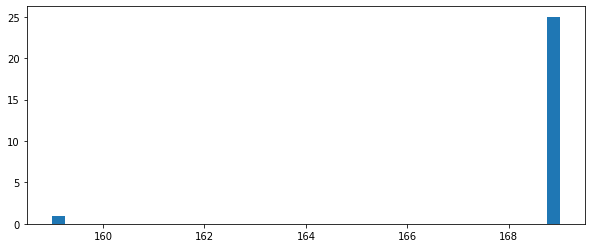

In [254]:
df_weather_test = pd.read_csv("./4_Testing_Weather_Data_2022.csv")
df_weather_test["Date"] = pd.to_datetime(df_weather_test["Date"].astype(str)).map(lambda s: s.dayofyear)
env_to_planting_date = df_meta_test.groupby("Env")["Date_Planted"].min()
df_weather_test["Date_Planted"] = df_weather_test["Env"].map(env_to_planting_date)
df_weather_test["Days_from_planting"] = df_weather_test["Date"] - df_weather_test["Date_Planted"]
df_weather_test["Date_Harvested"] = df_weather_test["Date_Planted"] + 170
plt.figure(figsize=(10, 4))
plt.hist(df_weather_test.loc[(df_weather_test["Days_from_planting"] >= 0) & (df_weather_test["Date"] < df_weather_test["Date_Harvested"])].\
    groupby("Env")["Days_from_planting"].max(), bins=40)
plt.show()

In [255]:
df_weather_test = df_weather_test.loc[
    (df_weather_test["Days_from_planting"] >= 0) & \
    (df_weather_test["Date"] < df_weather_test["Date_Harvested"])
].reset_index(drop=True)
df_weather_test["VPD"] = \
    610.78 * np.e**(df_weather_test[f"T2M"] / (df_weather_test[f"T2M"] + 237.3) * 17.2694)*(1 - df_weather_test["RH2M"]/100) / 1000
df_weather_test_averaged = df_weather_test.groupby("Env").apply(lambda df: average_by_periods(
    df,
    columns=list(set(df_weather_test.columns) - {'Env', 'Date', 'Date_Planted', 'Date_Harvested', 'df_weather_test.columns'}),
    n_periods=5,
)).reset_index()
df_weather_test_averaged["Year"] = df_weather_test_averaged["Env"].map(lambda s: int(s.split('_')[-1]))


In [256]:
df_weather_test_averaged = (df_weather_test_averaged[["Env", "Year"] + sorted(df_weather_test_averaged.columns[1:-1])]).copy()

In [257]:
scenarios = clusterer.predict(weather_scaler.transform(df_weather_test_averaged.iloc[:, 2:]))
df_weather_test_averaged["scenario"] = scenarios
pd.Series(scenarios).value_counts()


1    7
3    6
0    4
7    3
2    2
4    2
5    1
6    1
dtype: int64

In [259]:
df_weather_test_averaged.to_csv("./4_test_weather_averaged.csv", index=False)

### test strain

### test ec

In [200]:
df_ec_test = pd.read_csv("./6_Testing_EC_Data_2022.csv")
df_ec_test.isna().sum().max()

0

In [201]:
df_ec_test["Year"] = df_ec_test["Env"].map(lambda s: int(s.split('_')[-1]))

In [202]:
for growth_stage in growth_stages:
    for feature in ["SDR", "ESW", "Flow", "FlowNO3", "Flux", "PAWmm", "SWmm"]:
        try:
            df_ec_test[f"{feature}_{growth_stage}"] = sum([
                df_ec_test[f"{feature}_{growth_stage}_{soil_layer}"] for soil_layer in range(1, growth_stage_to_max_layer[growth_stage] + 1)
            ])
        except KeyError:
            pass
df_ec_test_filtered = pd.DataFrame()

df_ec_test_filtered["Env"] = df_ec_test["Env"]
df_ec_test_filtered["Year"] = df_ec_test["Year"]

df_ec_test_filtered["SDR_pGerEme"] = df_ec_test["SDR_pGerEme"]
df_ec_test_filtered["SDR_pEmeEnJ+pEnJFlo"] = df_ec_test["SDR_pEmeEnJ"]+df_ec_test["SDR_pEnJFlo"]
df_ec_test_filtered["SDR_pFloFla+pFlaFlw"] = df_ec_test["SDR_pFloFla"]+df_ec_test["SDR_pFlaFlw"]
df_ec_test_filtered["SDR_pFlwStG"] = df_ec_test["SDR_pFlwStG"]
df_ec_test_filtered["SDR_pStGEnG"] = df_ec_test["SDR_pStGEnG"]

df_ec_test_filtered["TT_pGerEme"] = df_ec_test["TT_pGerEme"]
df_ec_test_filtered["TT_pEmeEnJ+pEnJFlo"] = df_ec_test["TT_pEmeEnJ"]+df_ec_test["TT_pEnJFlo"]
df_ec_test_filtered["TT_pFloFla+pFlaFlw"] = df_ec_test["TT_pFloFla"]+df_ec_test["TT_pFlaFlw"]
df_ec_test_filtered["TT_pFlwStG"] = df_ec_test["TT_pFlwStG"]
df_ec_test_filtered["TT_pStGEnG"] = df_ec_test["TT_pStGEnG"]

df_ec_test_filtered["yield_pFloFla+pFlaFlw"] = df_ec_test["yield_pFloFla"]+df_ec_test["yield_pFlaFlw"]
df_ec_test_filtered["yield_pFlwStG"] = df_ec_test["yield_pFlwStG"]
df_ec_test_filtered["yield_pStGEnG"] = df_ec_test["yield_pStGEnG"]

df_ec_test_filtered["Eo_pFloFla+pFlaFlw"] = df_ec_test["Eo_pFloFla"]+df_ec_test["Eo_pFlaFlw"]
df_ec_test_filtered["Eo_pFlwStG"] = df_ec_test["Eo_pFlwStG"]
df_ec_test_filtered["Eo_pStGEnG"] = df_ec_test["Eo_pStGEnG"]

df_ec_test_filtered["ESW_pFloFla+pFlaFlw"] = df_ec_test["ESW_pFloFla"]+df_ec_test["ESW_pFlaFlw"]
df_ec_test_filtered["ESW_pFlwStG"] = df_ec_test["ESW_pFlwStG"]
df_ec_test_filtered["ESW_pStGEnG"] = df_ec_test["ESW_pStGEnG"]

df_ec_test_filtered["FlowNO3_pFloFla+pFlaFlw"] = df_ec_test["FlowNO3_pFloFla"]+df_ec_test["FlowNO3_pFlaFlw"]
df_ec_test_filtered["FlowNO3_pFlwStG"] = df_ec_test["FlowNO3_pFlwStG"]

df_ec_test_filtered["PAWmm_pFloFla+pFlaFlw"] = df_ec_test["PAWmm_pFloFla"]+df_ec_test["PAWmm_pFlaFlw"]
df_ec_test_filtered["PAWmm_pFlwStG"] = df_ec_test["PAWmm_pFlwStG"]
df_ec_test_filtered["PAWmm_pStGEnG"] = df_ec_test["PAWmm_pStGEnG"]

df_ec_test_filtered["LAI_pEmeEnJ+pEnJFlo"] = df_ec_test["LAI_pEmeEnJ"]+df_ec_test["LAI_pEnJFlo"]
df_ec_test_filtered["LAI_pFloFla+pFlaFlw"] = df_ec_test["LAI_pFloFla"]+df_ec_test["LAI_pFlaFlw"]

df_ec_test_filtered["AccumulatedTT_pGerEme"] = df_ec_test["AccumulatedTT_pGerEme"]
df_ec_test_filtered["AccumulatedTT_pEmeEnJ+pEnJFlo"] = df_ec_test["AccumulatedTT_pEmeEnJ"]+df_ec_test["AccumulatedTT_pEnJFlo"]
df_ec_test_filtered["AccumulatedTT_pFloFla+pFlaFlw"] = df_ec_test["AccumulatedTT_pFloFla"]+df_ec_test["AccumulatedTT_pFlaFlw"]
df_ec_test_filtered["AccumulatedTT_pFlwStG"] = df_ec_test["AccumulatedTT_pFlwStG"]
df_ec_test_filtered["AccumulatedTT_pStGEnG"] = df_ec_test["AccumulatedTT_pStGEnG"]

df_ec_test_filtered.shape

(24, 33)

In [203]:
df_ec_test_filtered.to_csv("./6_test_ec_cleaned.csv", index=False)